In [1]:
# imports and loadings
import os
import sys
sys.path.insert(0, '../functions/')
import mRNA_ratios as mr
import create_data_for_single_gene as cdg

import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

flags_df = pd.read_csv('../data/saved_flags.csv', index_col = 0)

# merge together log_tpm_df files
log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

tpm_df = 2**log_tpm_df

# settings
genes = ['b2818']#, 'b3959', 'b3958', 'b3359', 'b3957', 'b0273', 'b3172', 'b3960', 'b4254'] #'b1101', 'b1817', 'b1818', 'b1819', 
bott_pct = 0.01
top_pct = 0.01

In [2]:
# let's look at the data some

# rpoA and rpoZ don't correlate well with rpoB and rpoC which correlate well with each other, I think I focus on rpoB/rpoC
tpm_df.loc[['b3295', 'b3987', 'b3988', 'b3649']].T.corr() # rpoA, rpoB, rpoC, and rpoZ

,b3295,b3987,b3988,b3649
b3295,1.000000,0.635691,0.621349,-0.150456
b3987,0.635691,1.000000,0.951612,-0.326521
b3988,0.621349,0.951612,1.000000,-0.300423
b3649,-0.150456,-0.326521,-0.300423,1.000000


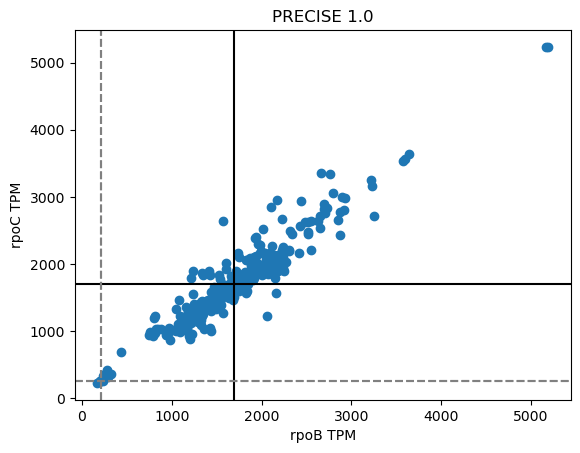

In [3]:
# visualize this
plt.scatter(tpm_df.loc['b3987'], tpm_df.loc['b3988'])
plt.axvline(x = np.median(tpm_df.loc['b3987']), c = 'k')
plt.axhline(y = np.median(tpm_df.loc['b3988']), c = 'k')

bott = tpm_df.loc['b3987'].sort_values().iloc[int(bott_pct*len(tpm_df.columns))]
top = tpm_df.loc['b3987'].sort_values().iloc[int(top_pct*len(tpm_df.columns))]
plt.axvline(x = bott, c = 'grey', ls = '--')
plt.axvline(x = top, c = 'grey', ls = '--')

bott = tpm_df.loc['b3988'].sort_values().iloc[int(bott_pct*len(tpm_df.columns))]
top = tpm_df.loc['b3988'].sort_values().iloc[int(top_pct*len(tpm_df.columns))]
plt.axhline(y = bott, c = 'grey', ls = '--')
plt.axhline(y = top, c = 'grey', ls = '--')

plt.title('PRECISE 1.0')
plt.xlabel('rpoB TPM')
plt.ylabel('rpoC TPM')
plt.show()

In [6]:
# let's find the fold change in the middle 95% percentile of this distribution, make the current RNAP the center, and scale thigns to both sides
# do this for both genes, each sample gets the RNAP value that's the average of both
RNAP_default = 10**-6
fold_modify = 2 # modify the fold amount by this factor (divided by if below, multiplied by if above)

genes = ['b3987', 'b3988']
RNAP_df = pd.DataFrame(index = tpm_df.columns)
for gene in genes:
    # calculations
    bott = tpm_df.loc[gene].sort_values().iloc[int(bott_pct*len(tpm_df.columns))]
    top = tpm_df.loc[gene].sort_values().iloc[int(top_pct*len(tpm_df.columns))]
    fold_change = top/bott
    middle = np.median(tpm_df.loc[gene])

    # scale everything
    new_col = []
    for sample in tpm_df.columns:
        # set outleirs to the min/max
        if tpm_df.loc[gene][sample] > top:
            tpm = top
        elif tpm_df.loc[gene][sample] < bott:
            tpm = bott
        else:
            tpm = tpm_df.loc[gene][sample]
        
        # scale to fold change, then by RNAP value
        fold_change = tpm / middle
        if tpm < middle:
            fold_change /= fold_modify
        else:
            fold_change *= fold_modify
        new_val = RNAP_default * fold_change
        
        new_col.append(new_val)
    RNAP_df[gene] = new_col

In [7]:
# save it off
RNAP_mean_df = pd.DataFrame(RNAP_df.mean(axis = 1))
RNAP_mean_df.columns = ['RNAP']
RNAP_mean_df.to_csv('../data/RNAP_conc.csv')

In [24]:
import parameter_optimization as po
import basal_model_calcs as bmc

eq_str = 'Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
            KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
            cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
            KeqOpening)*RNAP))'
flags = {'cell_constants' : {
    'RNAP': 1,
    'kDeg': 1,
    'promoterConcVal': 1,
    'TF': 0,
    'u': 1/3600,
     'mRNA_total': 1,
     'cell_volume': 1,
     'k_d_TF': 1,
},
        'central_gene' : 'b2818',
        'basal_conditions' : ['control__wt_glc__1', 'control__wt_glc__2'],
        'grid_use' : 2}
gene_grid_constants = bmc.basal_values(eq_str, flags)
lambda_df = po.create_lambdas(eq_str, gene_grid_constants)

In [35]:
lambda_df

,equation,lambda,order
cActivator,[KdRNAPCrp*(-cInhibitor*mRNARatio - 100000001....,<function _lambdifygenerated at 0x7fb649ccca60>,"(cInhibitor, KdRNAPCrp, mRNARatio)"
cInhibitor,[-cActivator - 100000001.0 + 100000000.0/mRNAR...,<function _lambdifygenerated at 0x7fb649ccf400>,"(cActivator, KdRNAPCrp, mRNARatio)"
KdRNAPCrp,[cActivator*(1.0 - mRNARatio)/(cActivator*mRNA...,<function _lambdifygenerated at 0x7fb649c2cd30>,"(cActivator, cInhibitor, mRNARatio)"
mRNARatio,[(100000000.0*KdRNAPCrp + cActivator)/(KdRNAPC...,<function _lambdifygenerated at 0x7fb649d24280>,"(cActivator, cInhibitor, KdRNAPCrp)"


In [30]:
import sympy

In [36]:

sympy.solve(lambda_df['equation'].loc['cActivator'], lambda_df['order'].loc['cActivator'])

[(cInhibitor, 0.0, mRNARatio),
 (-100000001.0 + 100000000.0/mRNARatio, KdRNAPCrp, mRNARatio)]